In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import json
import numpy as np
import requests
import tensorflow as tf
import pandas as pd
import cv2
import pickle
from keras_frcnn import roi_helpers

In [46]:
def format_img_size(img):
    """ formats the image size based on config """
    img_min_side = float(im_size)
    (height,width,_) = img.shape
        
    if width <= height:
        ratio = img_min_side/width
        new_height = int(ratio * height)
        new_width = int(img_min_side)
    else:
        ratio = img_min_side/height
        new_width = int(ratio * width)
        new_height = int(img_min_side)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    return img, ratio    

def format_img_channels(img):
    """ formats the image channels based on config """
    img = img[:, :, (2, 1, 0)]
    img = img.astype(np.float32)
    img[:, :, 0] -= img_channel_mean[0]
    img[:, :, 1] -= img_channel_mean[1]
    img[:, :, 2] -= img_channel_mean[2]
    img /= img_scaling_factor
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return img

def format_img(img):
    """ formats an image for model prediction based on config """
    img, ratio = format_img_size(img)
    img = format_img_channels(img)
    return img, ratio

def get_real_coordinates(ratio, x1, y1, x2, y2):
    real_x1 = int(round(x1 // ratio))
    real_y1 = int(round(y1 // ratio))
    real_x2 = int(round(x2 // ratio))
    real_y2 = int(round(y2 // ratio))
    return (real_x1, real_y1, real_x2 ,real_y2)

In [4]:
config_output_filename = 'model/config.pickle'
with open(config_output_filename, 'rb') as f_in:
    C = pickle.load(f_in)

In [5]:
r = requests.get('http://localhost:9000/v1/models/rpn/metadata')
res = dict(json.loads(r.content.decode('utf-8')))

In [6]:
im_size = 600
img_channel_mean = [103.939, 116.779, 123.68]
img_scaling_factor = 1.0

In [7]:
res['metadata']['signature_def']['signature_def']['serving_default']['inputs']

{'input': {'dtype': 'DT_FLOAT',
  'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
    {'size': '600', 'name': ''},
    {'size': '600', 'name': ''},
    {'size': '3', 'name': ''}],
   'unknown_rank': False},
  'name': 'input_3:0'}}

In [23]:
import cv2
im_path = '/home/ritesh/Dkube-Demos/test/Nucleoplasm_Cytosol/0cfbad10-bbb7-11e8-b2ba-ac1f6b6435d0.png'
img = cv2.imread(im_path)

In [24]:
X, ratio = format_img(img)

X = np.transpose(X, (0, 2, 3, 1))

In [25]:
X.shape

(1, 600, 600, 3)

In [26]:
payload = {
    "inputs": {'input': X.tolist()}
}
r = requests.post('http://localhost:9000/v1/models/rpn:predict', json=payload)

In [27]:
r

<Response [200]>

In [28]:
pred = json.loads(r.content.decode('utf-8'))

In [29]:
pred['outputs'].keys()

dict_keys(['rpn_out_class_1/Sigmoid:0', 'activation_88/Relu:0', 'rpn_out_regress_1/BiasAdd:0'])

In [30]:
Y1 = np.asarray(pred['outputs']['rpn_out_class_1/Sigmoid:0'])
Y2 = np.asarray(pred['outputs']['rpn_out_regress_1/BiasAdd:0'])
F = np.asarray(pred['outputs']['activation_88/Relu:0'])

In [31]:
Y1.shape, Y2.shape, F.shape

((1, 38, 38, 9), (1, 38, 38, 36), (1, 38, 38, 1024))

In [32]:
r = requests.get('http://localhost:9001/v1/models/clf/metadata')
res = dict(json.loads(r.content.decode('utf-8')))

In [33]:
res['metadata']['signature_def']['signature_def']['serving_default']['inputs']

{'input_4:0': {'dtype': 'DT_FLOAT',
  'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
    {'size': '32', 'name': ''},
    {'size': '4', 'name': ''}],
   'unknown_rank': False},
  'name': 'input_4:0'},
 'input_5:0': {'dtype': 'DT_FLOAT',
  'tensor_shape': {'dim': [{'size': '-1', 'name': ''},
    {'size': '38', 'name': ''},
    {'size': '38', 'name': ''},
    {'size': '1024', 'name': ''}],
   'unknown_rank': False},
  'name': 'input_5:0'}}

In [34]:
R = roi_helpers.rpn_to_roi(Y1, Y2, C, overlap_thresh=0.7)
R[:, 2] -= R[:, 0]
R[:, 3] -= R[:, 1]

In [55]:
bboxes = {}
probs = {}
all_imgs = []
classes = {}
bbox_threshold = 0.5
visualise = True
class_mapping = {0: 'Nucleoplasm',1: 'Cytosol',2: 'bg'}
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

In [56]:
for jk in range(R.shape[0]//C.num_rois + 1):
    ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
    if ROIs.shape[1] == 0:
        break

    if jk == R.shape[0]//C.num_rois:
        #pad R
        curr_shape = ROIs.shape
        target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
        ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
        ROIs_padded[:, :curr_shape[1], :] = ROIs
        ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
        ROIs = ROIs_padded
    payload = {
            "inputs": {'input_5:0': F.tolist(), 'input_4:0': ROIs.tolist() }
            }
    r = requests.post('http://localhost:9001/v1/models/clf:predict', json=payload)
    pred = json.loads(r.content.decode('utf-8'))
    P_cls = np.asarray(pred['outputs']['dense_class_3_1/Reshape_1:0'])
    P_regr = np.asarray(pred['outputs']['dense_regress_3_1/Reshape_1:0'])
    for ii in range(P_cls.shape[1]):
        if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
            continue

        cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]
        if cls_name not in bboxes:
            bboxes[cls_name] = []
            probs[cls_name] = []

        (x, y, w, h) = ROIs[0, ii, :]

        cls_num = np.argmax(P_cls[0, ii, :])
        try:
            (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
            tx /= C.classifier_regr_std[0]
            ty /= C.classifier_regr_std[1]
            tw /= C.classifier_regr_std[2]
            th /= C.classifier_regr_std[3]
            x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
        except:
            pass
        bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
        probs[cls_name].append(np.max(P_cls[0, ii, :]))
all_dets = []
for key in bboxes:
    bbox = np.array(bboxes[key])

    new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
    for jk in range(new_boxes.shape[0]):
        (x1, y1, x2, y2) = new_boxes[jk,:]

        (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

        cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),2)

        textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
        all_dets.append((key,100*new_probs[jk]))

        (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
        textOrg = (real_x1, real_y1-0)

        cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
        cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
        cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)
cv2.imwrite('reslult.png',img)
    

True

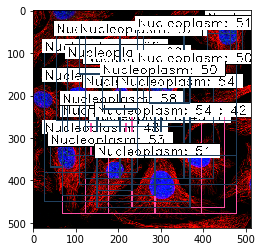

In [57]:
import matplotlib.pyplot as plt
plt.imshow(img)